## Model definition

In [19]:
!pip install numpy torch --index-url https://download.pytorch.org/whl/cpu
#!pip install scikit-learn pandas torch

Looking in indexes: https://download.pytorch.org/whl/cpu


### Define a model

In [20]:
import torch.nn as nn

class GenderClassifier(nn.Module):

    def __init__(self, input_size: int, hidden1_size: int, hidden2_size: int, output_size: int):
        super(GenderClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))

        return x


### Load and prepare dataset

In [21]:
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
import pandas as pd

df = pd.read_csv("data/hr_data_gold.csv")

label = 'Gender_Male'
features = [c for c in df.columns if c != label]

# create tensors
X = torch.tensor(df[features].values, dtype=torch.float32)
y = torch.tensor(df[label], dtype=torch.long)

# create tensor dataframe
ds = TensorDataset(X, y)

# split data
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
ds_train, ds_test = random_split(ds, [train_size, test_size])

# create loaders
all_loader  = DataLoader(ds, batch_size=1, shuffle=False)
train_loader = DataLoader(ds_train, batch_size=8, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=1, shuffle=True)

### Learn model 48 x 24

In [23]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

#model = torch.load("model_24_48_b32.pt", weights_only=False)
model = GenderClassifier(len(features), 48, 24, 2)

train_accuracy_log = []
test_accuracy_log = []

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 300

for epoch in range(epochs):
    # train
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

    # calculate train_ds and test_ds accuracy
    with torch.no_grad():
        model.eval()
        train_features, train_labels = ds_train[:][0], ds_train[:][1]
        # Process all features at once
        train_pred = model(train_features).argmax(dim=1)
        train_accuracy = accuracy_score(train_labels, train_pred)
        train_accuracy_log.append(train_accuracy)

        test_features, test_labels = ds_test[:][0], ds_test[:][1]
        # Process all features at once
        test_pred = model(test_features).argmax(dim=1)
        test_accuracy = accuracy_score(test_labels, test_pred)
        test_accuracy_log.append(test_accuracy)

    
    print(f"Progress: {epoch / epochs * 100:.1f} %")

Progress: 0.0 %
Progress: 0.3 %
Progress: 0.7 %
Progress: 1.0 %
Progress: 1.3 %
Progress: 1.7 %
Progress: 2.0 %
Progress: 2.3 %
Progress: 2.7 %
Progress: 3.0 %
Progress: 3.3 %
Progress: 3.7 %
Progress: 4.0 %
Progress: 4.3 %
Progress: 4.7 %
Progress: 5.0 %
Progress: 5.3 %
Progress: 5.7 %
Progress: 6.0 %
Progress: 6.3 %
Progress: 6.7 %
Progress: 7.0 %
Progress: 7.3 %
Progress: 7.7 %
Progress: 8.0 %
Progress: 8.3 %
Progress: 8.7 %
Progress: 9.0 %
Progress: 9.3 %
Progress: 9.7 %
Progress: 10.0 %
Progress: 10.3 %
Progress: 10.7 %
Progress: 11.0 %
Progress: 11.3 %
Progress: 11.7 %
Progress: 12.0 %
Progress: 12.3 %
Progress: 12.7 %
Progress: 13.0 %
Progress: 13.3 %
Progress: 13.7 %
Progress: 14.0 %
Progress: 14.3 %
Progress: 14.7 %
Progress: 15.0 %
Progress: 15.3 %
Progress: 15.7 %
Progress: 16.0 %
Progress: 16.3 %
Progress: 16.7 %
Progress: 17.0 %
Progress: 17.3 %
Progress: 17.7 %
Progress: 18.0 %
Progress: 18.3 %
Progress: 18.7 %
Progress: 19.0 %
Progress: 19.3 %
Progress: 19.7 %
Progress: 

### Learning curve

In [24]:
!pip install -q matplotlib seaborn

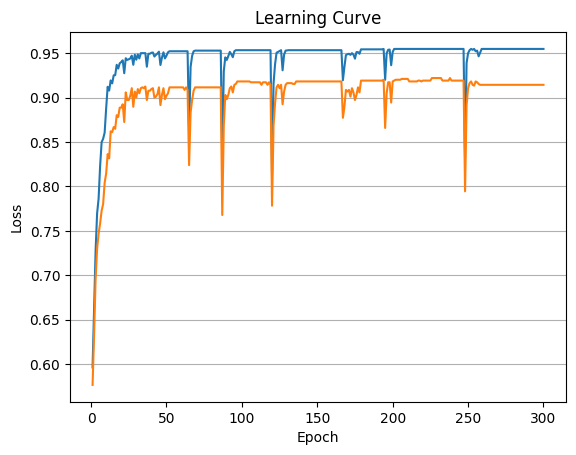

In [25]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
x = list(range(1, epochs + 1))

plt.plot(x, train_accuracy_log, label="Train accuracy")
plt.plot(x, test_accuracy_log, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.grid(axis = 'y')
plt.show()

### Validation
- Accuracy
- Precusion
- Recall
- Confusion Matrix

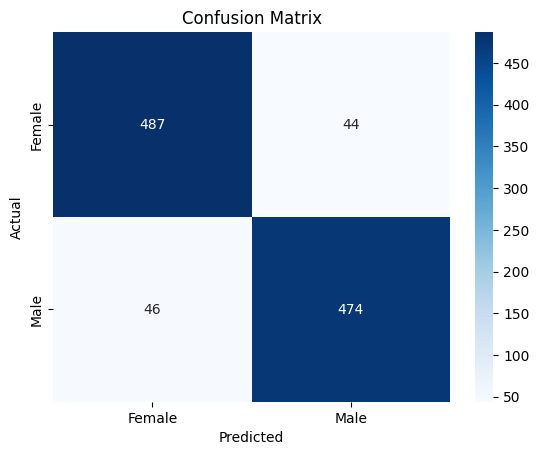

Accuracy:  0.9144
Precision: 0.9151
Recall:    0.9115
F1 Score:  0.9133


In [26]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        outputs = model(X)
        preds = torch.argmax(outputs, dim=1)
        all_labels.append(y)
        all_preds.append(preds)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Female", "Male"], yticklabels=["Female", "Male"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

In [129]:
#torch.save(model, "model_24_48_b8_e1000.pt")

In [124]:
#model1 = torch.load("model.pt", weights_only=False)

### Feature importance analysis

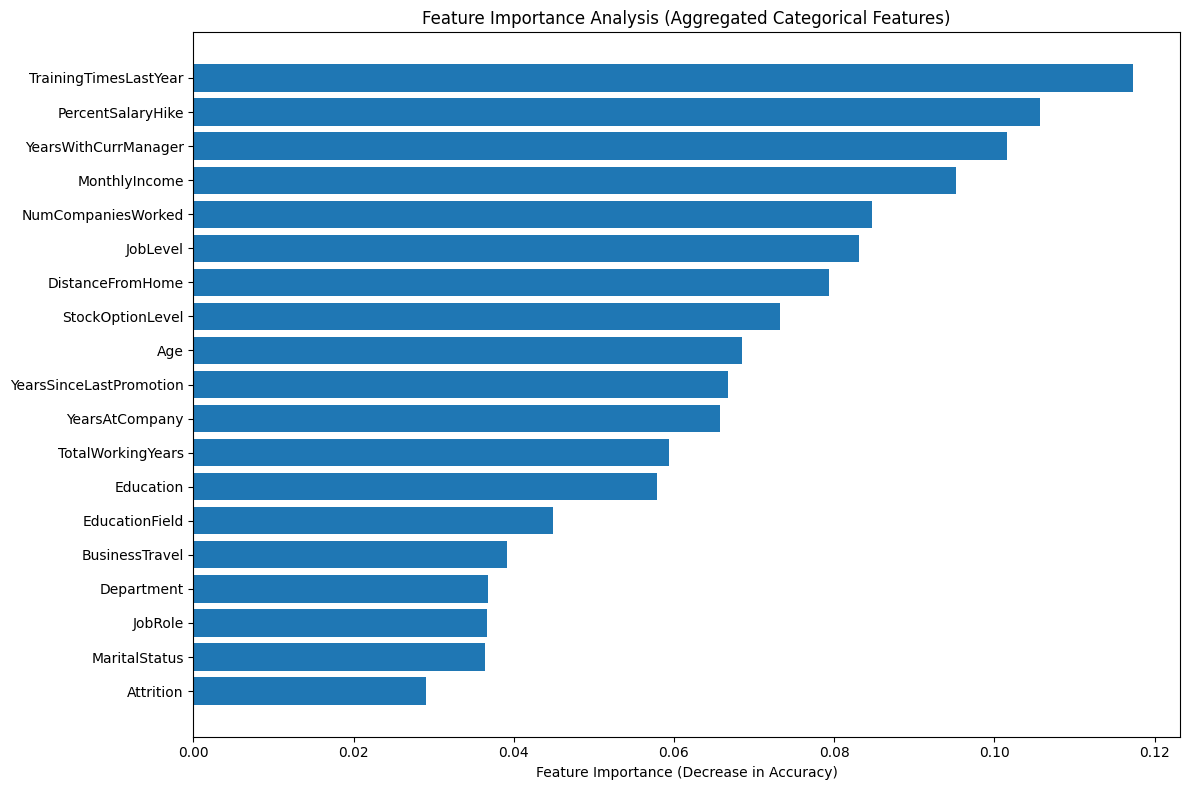


Feature Importance Scores:
Attrition: 0.0290
MaritalStatus: 0.0363
JobRole: 0.0367
Department: 0.0368
BusinessTravel: 0.0392
EducationField: 0.0449
Education: 0.0578
TotalWorkingYears: 0.0594
YearsAtCompany: 0.0657
YearsSinceLastPromotion: 0.0668
Age: 0.0685
StockOptionLevel: 0.0733
DistanceFromHome: 0.0794
JobLevel: 0.0831
NumCompaniesWorked: 0.0848
MonthlyIncome: 0.0952
YearsWithCurrManager: 0.1015
PercentSalaryHike: 0.1057
TrainingTimesLastYear: 0.1173


In [27]:


### Feature importance analysis with aggregated categorical features
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def calculate_permutation_importance(model, X, y, feature_names, n_repeats=10):
    baseline_score = accuracy_score(y, model(X).argmax(dim=1))
    importance_scores = []
    
    for feature_idx in range(X.shape[1]):
        feature_scores = []
        for _ in range(n_repeats):
            X_permuted = X.clone()
            X_permuted[:, feature_idx] = X_permuted[:, feature_idx][torch.randperm(X.shape[0])]
            score = accuracy_score(y, model(X_permuted).argmax(dim=1))
            feature_scores.append(baseline_score - score)
        importance_scores.append(np.mean(feature_scores))
    
    return importance_scores

# Get test data
test_features, test_labels = ds_test[:][0], ds_test[:][1]

# Calculate feature importance
importance_scores = calculate_permutation_importance(model, test_features, test_labels, features)

# Group related features
feature_groups = {
    'EducationField': [f for f in features if f.startswith('EducationField_')],
    'Department': [f for f in features if f.startswith('Department_')],
    'JobRole': [f for f in features if f.startswith('JobRole_')],
    'BusinessTravel': [f for f in features if f.startswith('BusinessTravel_')],
    'MaritalStatus': [f for f in features if f.startswith('MaritalStatus_')]
}

# Calculate aggregated importance scores
aggregated_scores = {}
for group_name, group_features in feature_groups.items():
    if group_features:
        group_indices = [features.index(f) for f in group_features]
        aggregated_scores[group_name] = np.mean([importance_scores[i] for i in group_indices])

# Add individual numeric features
numeric_features = [f for f in features if f not in [item for sublist in feature_groups.values() for item in sublist]]
for feature in numeric_features:
    aggregated_scores[feature] = importance_scores[features.index(feature)]

# Sort features by importance
sorted_features = sorted(aggregated_scores.items(), key=lambda x: x[1])
feature_names = [f[0] for f in sorted_features]
scores = [f[1] for f in sorted_features]

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_names)), scores)
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Feature Importance (Decrease in Accuracy)')
plt.title('Feature Importance Analysis (Aggregated Categorical Features)')
plt.tight_layout()
plt.show()

# Print all features with their importance scores
print("\nFeature Importance Scores:")
for feature, score in sorted_features:
    print(f"{feature}: {score:.4f}")

In [66]:
df_silver = pd.read_csv("data/hr_data_silver.csv")
all_money = df_silver["MonthlyIncome"]
man_money = df_silver[df_silver["Gender"] == "Male"]["MonthlyIncome"]

all_size = len(all_money)
man_size = len(man_money)
man_percentage = man_size/all_size

all_money = all_money.sum()
man_money = man_money.sum()*0.5/(man_size/all_size)

print(f"Man money part: {man_money/all_money}")

Man money part: 0.5020158948228891
